In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
inspector = inspect(engine)

In [10]:
# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [11]:
# Using the inspector to print the column names within the 'measurement' table and its types
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Using the inspector to print the column names within the 'station' table and its types
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Find the most recent date in the data set.
first_date = session.query(Measurement.date).order_by(Measurement.date).first()
first_date

('2010-01-01')

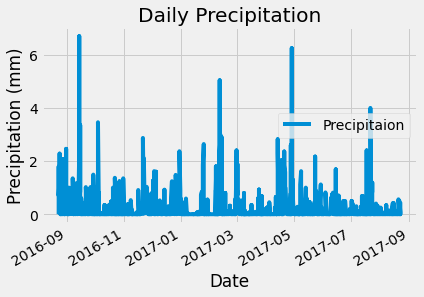

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set
# Perform a query to retrieve the data and precipitation scores
months_12 = session.query(Measurement.date, Measurement.prcp).\
                    filter(Measurement.date > '2016-08-22').\
                    order_by(Measurement.date).\
                    all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(months_12, columns = ['Date', 'Precipitaion'])
prcp_df['Date'] = pd.to_datetime(prcp_df['Date'])

# Sort the dataframe by date
prcp_df = prcp_df.sort_values("Date").dropna().set_index("Date")

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(title='Daily Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (mm)')
plt.show()

In [22]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,Precipitaion
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset


In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [20]:
# Close Session
session.close()